## Media Monitor Analysis

Part of a joint research project between the [School of Computer Science](https://www.cs.cf.ac.uk/) and the [School of Journalism](http://www.cardiff.ac.uk/journalism-media-cultural-studies) at Cardiff University. 

---

*This notebook requires a mongoDB database called **`media-monitor`** with a **`tweets`** collection containing [Tweet objects](https://dev.twitter.com/overview/api/tweets). It aims to analyse the data collected by the [media-monitor](https://github.com/taylorrees/media-monitor) tool.*

### Key Terms

**`JOI`** Journalists of interest

**`OOI`** Organisations of interest

**`EXT`** Accounts not followed by streaming api

### Getting Started

To get started import the dependencies. 

*We also need to extend the `Collect` class to cater to our needs as we want the store method to clear a specified collection everytime it is called.*

In [2]:
from json import load
from collect import Collect
from db import DB

# allow inline plotting
%matplotlib inline
import matplotlib.pyplot as plt

class Collect(Collect):
    def store(self, collection):
        # extend and alter store
        DB[collection].delete_many({})
        DB[collection].insert_many(self.members)

Next, setup new collections in the database.

_**Note**_

Only call if the journalists and organisations collections are not already setup in the database. This will read the JSON files containing journalist and organisation twitter lists and store them in the appropriate database.

In [ ]:
# get & store journalists from twitter lists
j = load(open("journalists.json"))
collect = Collect(lists=j)
collect.store("journalists")

# get & store news organisations from twitter lists
o = load(open("organisations.json"))
collect = Collect(lists=o, refine=False, append=True)
collect.store("organisations")

### Original Tweet Analysis

This section of the analysis aims to look at the number of original tweets authored throughout the data collection period. An original tweet is one that has been published by a user that is not a reply nor a retweet. We will look for tweets authored by the `JOI`, `OOI` and `EXT` accounts. 

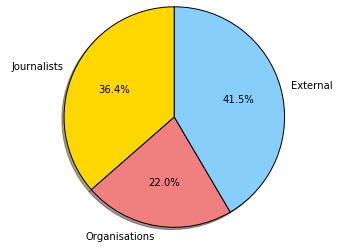

In [11]:
# get sets of id_str's
journalists = DB.journalists.distinct("id_str")
organisations = DB.organisations.distinct("id_str")

_all = DB.tweets.find({
    "in_reply_to_status_id_str": {"$eq": None},
    "retweeted_status": {"$exists": False}
}).count()

joi = DB.tweets.find({
    "user.id_str": {"$in": journalists},
    "in_reply_to_status_id_str": {"$eq": None},
    "retweeted_status": {"$exists": False}
}).count()

ooi = DB.tweets.find({
    "user.id_str": {"$in": organisations},
    "in_reply_to_status_id_str": {"$eq": None},
    "retweeted_status": {"$exists": False}
}).count()

ext = DB.tweets.find({
    "user.id_str": {"$nin": (journalists + organisations)},
    "in_reply_to_status_id_str": {"$eq": None},
    "retweeted_status": {"$exists": False}
}).count()

joi = (joi / _all) * 100
ooi = (joi / _all) * 100
joi = (joi / _all) * 100

# data to plot
labels = "Journalists", "Organisations", "External"
sizes = [215, 130, 245]
colors = ['gold', 'lightcoral', 'lightskyblue']

# plot
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
        shadow=True, startangle=90)

plt.axis('equal')
plt.show()
